# Variational Quantum Algorithms with Qiskit Runtime: <br> Ground State of a Molecule

In this exercise, use Qiskit Runtime to find the approximate ground state energy of the $H_2$ molecule, with interatomic distance 0.72 angstroms.

_Hints_

- Start with the [notebook implementing a generic VQA](Part3_VQA_Generic.ipynb) and modify the input problem to accept an electronic structure problem.
<br>

- For help on setting up an electronic structure problem for $H_2$, check out [this tutorial from Qiskit Nature](https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html). 
<br>

- It's recommended you use pyscf for the [`ElectronicStructureMoleculeDriver`](https://qiskit.org/documentation/nature/stubs/qiskit_nature.drivers.second_quantization.ElectronicStructureMoleculeDriver.html) and [`ParityMapper` for the qubit conversion](https://qiskit.org/documentation/nature/stubs/qiskit_nature.mappers.second_quantization.ParityMapper.html) (to reduce the system size down to 2 qubits). 
<br>

- You can test different classical optimizers (e.g., [`NELDER_MEAD`](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.NELDER_MEAD.html)) and circuit ansatzae (e.g., [`RealAmplitudes`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html))
<br>

- Once you get the expectation value from the qubit Hamiltonian, add back in the nuclear repulsion energy using the `total_energies` method of the `ElectronicStructureResult` documented [here](https://qiskit.org/documentation/nature/stubs/qiskit_nature.results.ElectronicStructureResult.total_energies.html#qiskit_nature.results.ElectronicStructureResult.total_energies).

## A Solution...

**Define the H2 molecule and the classical driver**

In [1]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver

dist = 0.72
molecule = Molecule(geometry=[['H', [0., 0., 0.]], ['H', [0., 0., dist]]])
driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', \
                                           driver_type=ElectronicStructureDriverType.PYSCF)

print(molecule)

Molecule:
	Multiplicity: 1
	Charge: 0
	Unit: Angstrom
	Geometry:
		H	[0.0, 0.0, 0.0]
		H	[0.0, 0.0, 0.72]


**Set up the electronic structure problem and build the second quantized hamiltonian**

In [2]:
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

es_problem = ElectronicStructureProblem(driver)
second_q_ops = es_problem.second_q_ops()
print(second_q_ops[0])

Fermionic Operator
register length=4, number terms=36
  -1.2654933108286723 * ( +_0 -_0 )
+ -0.4620859696969096 * ( +_1 -_1 )
+ -1.2654933108286723 * ( +_2 -_2 )
+ -0.4620859696969096 * ( +_3 -_3 )
+ -0.3392865978929373 * ( +_0 +_0 -_0 -_0 )
+ -0.090 ...


**Convert the second quantized hamiltonian to a qubit hamiltonian**

In [3]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper

qubit_converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)
hamiltonian = qubit_converter.convert(second_q_ops[0], num_particles=es_problem.num_particles)
print(hamiltonian)

-1.048994064841825 * II
+ 0.4073995404106219 * IZ
- 0.40739954041062354 * ZI
- 0.011379719791600448 * ZZ
+ 0.18009856566184662 * XX


**Let's solve this problem exactly using a numpy minimum eigensolver**

In [4]:
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms import MinimumEigensolverResult

# Generate the exact solution
sol = MinimumEigensolverResult()
sol.eigenvalue = NumPyMinimumEigensolver().compute_minimum_eigenvalue(hamiltonian).eigenvalue
exact_solution = es_problem.interpret(sol).total_energies[0]

print('exact_solution:\n{}'.format(exact_solution))

exact_solution:
-1.137111715115462


**Before we can use Qiskit Runtime to solve, we need to convert the hamiltonian into an [opflow op](https://qiskit.org/documentation/apidoc/opflow.html)**

In [5]:
from qiskit.opflow import TaperedPauliSumOp
import numpy as np

ops = []
h = hamiltonian.primitive
h.coeffs = np.real(hamiltonian.coeffs)
ops.append(TaperedPauliSumOp(h, hamiltonian.z2_symmetries))

**Let's start the qiskit runtime service and define our problem inputs**

We'll choose a backend, a classical optimizer, and a circuit ansatz for the ground state.

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
service = QiskitRuntimeService()
options = {"backend" : "ibmq_qasm_simulator"}

from qiskit.algorithms.optimizers import NELDER_MEAD
from qiskit.circuit.library import RealAmplitudes
circuit = RealAmplitudes(num_qubits=hamiltonian.num_qubits, reps=2)

**This is what our circuit looks like**

In [7]:
circuit.decompose().draw()

┌──────────┐     ┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├──■──┤ Ry(θ[4]) ├
     ├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├
     └──────────┘└───┘└──────────┘└───┘└──────────┘

**Now, we can use the Estimator code from the generic VQA example**

In [8]:
convergence = []

with Estimator(
    circuits=circuit,
    observables=ops,
    options=options,
    service=service
) as estimator:
    
    def evaluate_expectation(x):
        x = list(x)
        results = estimator(circuits=[0], observables=[0], parameter_values=[x]).values[0]
        return np.real(results)

    def callback(fx):
        expval = evaluate_expectation(fx)
        print('expval: {}'.format(expval))
        convergence.append(expval)

    np.random.seed(1)
    initial_point = np.random.uniform(-np.pi, np.pi, len(circuit.parameters))
    optimizer = NELDER_MEAD(40, callback=callback)
    result = optimizer.minimize(fun=evaluate_expectation, x0=initial_point)


expval: -1.0709425274497646
expval: -1.083314298722292
expval: -1.0887286322073177
expval: -1.1519610995814205
expval: -1.1951755955523224
expval: -1.1972795493299202
expval: -1.3412786636638436
expval: -1.3400985559996337
expval: -1.320539403654403
expval: -1.5378991469943188
expval: -1.548941573766889
expval: -1.5315590433349964
expval: -1.7702814040672448
expval: -1.7983754419711757
expval: -1.800460470988544
expval: -1.7681832355829854
expval: -1.7856082808737928
expval: -1.766199472208579
expval: -1.7710815275044796
expval: -1.7775368403796818
expval: -1.7981211175918743
expval: -1.7666760829612842
expval: -1.78316302271693
expval: -1.7821406784593512
expval: -1.7845774493771651
expval: -1.778377278097903
expval: -1.8022189695268154
expval: -1.8787261530232462
expval: -1.8519370785251725
expval: -1.8481992054339307
expval: -1.870987555890576
expval: -1.839140542035766
expval: -1.8423631507478166
expval: -1.8487882972355811
expval: -1.8619895542267544
expval: -1.856260234628084
exp

**We'll add the contribution of the nuclear repulsion energy from the driver to get the total energy**

In [9]:
total_energy = []
for i in range(len(convergence)):
    sol = MinimumEigensolverResult()
    sol.eigenvalue = convergence[i]
    sol = es_problem.interpret(sol).total_energies[0]
    total_energy.append(sol)

print(total_energy)

[-0.33597417894976456, -0.34834595022229187, -0.3537602837073177, -0.4169927510814204, -0.4602072470523224, -0.46231120082992017, -0.6063103151638436, -0.6051302074996336, -0.5855710551544029, -0.8029307984943188, -0.813973225266889, -0.7965906948349963, -1.0353130555672447, -1.0634070934711757, -1.0654921224885439, -1.0332148870829854, -1.0506399323737927, -1.031231123708579, -1.0361131790044795, -1.0425684918796818, -1.0631527690918743, -1.0317077344612842, -1.04819467421693, -1.0471723299593512, -1.049609100877165, -1.043408929597903, -1.0672506210268153, -1.1437578045232462, -1.1169687300251725, -1.1132308569339306, -1.136019207390576, -1.104172193535766, -1.1073948022478166, -1.113819948735581, -1.1270212057267543, -1.121291886128084, -1.109501497302961, -1.1330482473333403, -1.1316099147255634]


**And, finally, let's plot the convergence of our algorithm**

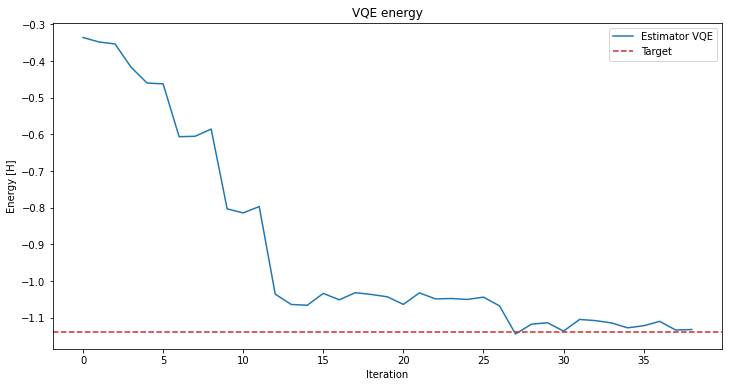

In [10]:
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

plt.figure(figsize=(12, 6))
plt.plot(total_energy, label="Estimator VQE")
plt.axhline(y=exact_solution, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [11]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.6.0'

In [12]:
from qiskit.tools.jupyter import *

%qiskit_version_table
%qiskit_copyright